In [2]:
from __future__ import division, print_function
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import files
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
uploaded = files.upload()
# 1. Загрузка данных
data_path = 'Mall_Customers.csv'
df = pd.read_csv(data_path)

# Анализ структуры данных
print(df.info())
print(df.describe())

Saving Mall_Customers.csv to Mall_Customers (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000      

In [3]:
# Создаем целевой столбец target: Spending Score > медианы — класс 1, иначе — класс 0
df['target'] = (df['Spending Score (1-100)'] > df['Spending Score (1-100)'].median()).astype(int)

# 2.1 Создание синтезированных признаков
# Нормализация Annual Income на Age (доход на год возраста)
df['income_per_age'] = df['Annual Income (k$)'] / df['Age']

# Учитываем только числовые признаки для модели
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'income_per_age']]
y = df['target']  # целевая переменная

# Вывод выбранных признаков
print("\nПризнаки для обучения:")
print(X.head())

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Замена NaN значений на медиану
X_train = X_train.apply(lambda x: x.fillna(x.median()), axis=0)
X_test = X_test.apply(lambda x: x.fillna(x.median()), axis=0)
y_train = y_train.fillna(y_train.median())
y_test = y_test.fillna(y_test.median())

# Просмотр размеров тренировочного и тестового наборов
print("\nРазмеры наборов данных:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Вывод первых 5 строк после масштабирования
print("\nПервые 5 строк после масштабирования:")
print(X_train_scaled[:5])


Признаки для обучения:
   Age  Annual Income (k$)  Spending Score (1-100)  income_per_age
0   19                  15                      39        0.789474
1   21                  15                      81        0.714286
2   20                  16                       6        0.800000
3   23                  16                      77        0.695652
4   31                  17                      40        0.548387

Размеры наборов данных:
X_train: (160, 4), X_test: (40, 4)
y_train: (160,), y_test: (40,)

Первые 5 строк после масштабирования:
[[ 0.73027906 -0.24190423 -0.37113766 -0.65435052]
 [-0.50042667  2.39455436  0.84383985  2.2247354 ]
 [-0.21084885 -0.8644014  -0.97862642 -0.72975618]
 [ 1.09225134 -1.19395872 -1.43424298 -1.24685097]
 [ 0.07872897  0.30735798  0.23635109 -0.02180641]]


In [4]:
# 2.2 Обучение логистической регрессии с подбором гиперпараметра C
params = {'C': np.logspace(-3, 3, 10)}  # Сетка значений гиперпараметра
lr = LogisticRegression(max_iter=1000, random_state=42)  # Создаем модель логистической регрессии

# GridSearchCV для поиска лучшего C с кросс-валидацией
grid = GridSearchCV(lr, params, scoring='roc_auc', cv=5)
grid.fit(X_train_scaled, y_train)

# Получаем оптимальный гиперпараметр
best_model = grid.best_estimator_
best_C = grid.best_params_['C']
print(f"Лучшее значение C: {best_C}")

# Вывод результатов
print("\nЛучшие параметры модели:")
print(best_model)

# Оценка на тестовых данных
test_score = best_model.score(X_test_scaled, y_test)
print(f"Точность на тестовой выборке: {test_score:.4f}")

Лучшее значение C: 0.46415888336127775

Лучшие параметры модели:
LogisticRegression(C=0.46415888336127775, max_iter=1000, random_state=42)
Точность на тестовой выборке: 1.0000


In [7]:
# 2.3 Оценка модели

# Предсказание вероятностей для тестовой выборки
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]  # Вероятности для класса 1

# Вычисление AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_prob)  # AUC-ROC: диапазон от 0 до 1
print(f"AUC-ROC: {auc_score:.4f}")

AUC-ROC: 1.0000


In [8]:
# Список значений гиперпараметра C
Cs = np.logspace(-1, 2, 10)

# Список для хранения значений AUC-ROC для каждого C
scores = []

# Обучение модели и расчет AUC-ROC для каждого значения C
for C_val in Cs:
    lr = LogisticRegression(C=C_val, max_iter=1000, random_state=42)
    # Обучение модели на тренировочных данных
    lr.fit(X_train_scaled, y_train)

    # Получение вероятностей для расчета AUC-ROC
    y_pred_prob = lr.predict_proba(X_test_scaled)[:, 1]

    # Расчет AUC-ROC на основе меток класса в тестовой выборке y_test и предсказанных вероятностей y_pred_prob
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)

# Вывод значений AUC-ROC для каждого C
print("Значения AUC-ROC для каждого C:")
for i, C_val in enumerate(Cs):
    print(f"C={C_val:.3f}, AUC-ROC={scores[i]:.4f}")

# Оптимальное значение C
best_C_index = np.argmax(scores)
best_C = Cs[best_C_index]
print(f"\nОптимальное значение C: {best_C:.3f}, максимальный AUC-ROC: {scores[best_C_index]:.4f}")

Значения AUC-ROC для каждого C:
C=0.100, AUC-ROC=0.9949
C=0.215, AUC-ROC=1.0000
C=0.464, AUC-ROC=1.0000
C=1.000, AUC-ROC=1.0000
C=2.154, AUC-ROC=1.0000
C=4.642, AUC-ROC=1.0000
C=10.000, AUC-ROC=1.0000
C=21.544, AUC-ROC=0.9974
C=46.416, AUC-ROC=0.9974
C=100.000, AUC-ROC=0.9974

Оптимальное значение C: 0.215, максимальный AUC-ROC: 1.0000


In [9]:
# Создание и обучение модели логистической регрессии с дефолтным C=1
lr_default = LogisticRegression(C=1, max_iter=1000, random_state=42)

# Обучение модели на тренировочных данных
lr_default.fit(X_train_scaled, y_train)

# Предсказание вероятностей для тестового набора
y_pred_prob_default = lr_default.predict_proba(X_test_scaled)[:, 1]

# Вычисление AUC-ROC для дефолтного C=1
score_C_1 = roc_auc_score(y_test, y_pred_prob_default)

# Вывод результата
print(f"AUC-ROC для модели с C=1: {score_C_1:.4f}")

AUC-ROC для модели с C=1: 1.0000


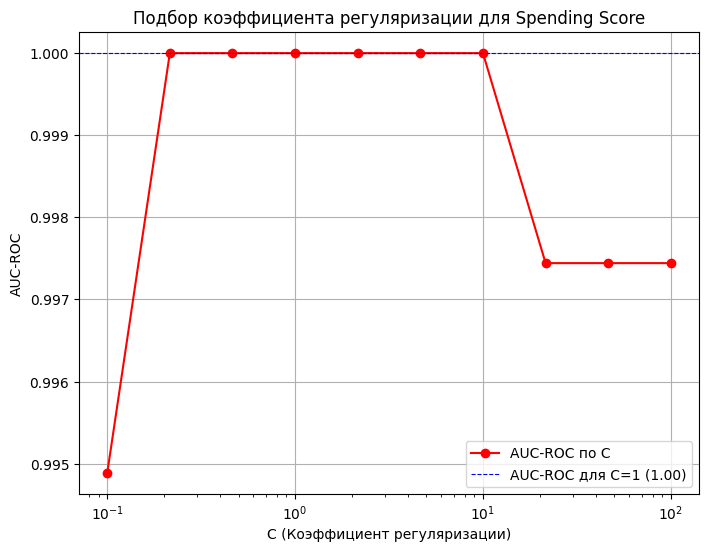

In [10]:
# Построение графика AUC-ROC от значений C
plt.figure(figsize=(8, 6))
plt.plot(Cs, scores, 'ro-', label='AUC-ROC по C')  # Cs - список значений C, scores - AUC-ROC для каждого C
plt.xscale('log')  # Логарифмическая шкала по оси X
plt.xlabel('C (Коэффициент регуляризации)')
plt.ylabel('AUC-ROC')
plt.title('Подбор коэффициента регуляризации для Spending Score')

# Горизонтальная линия для AUC-ROC с дефолтным C=1
plt.axhline(y=score_C_1, linewidth=0.8, color='b', linestyle='dashed',
            label=f'AUC-ROC для C=1 ({score_C_1:.2f})')

# Настройка легенды и сетки
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

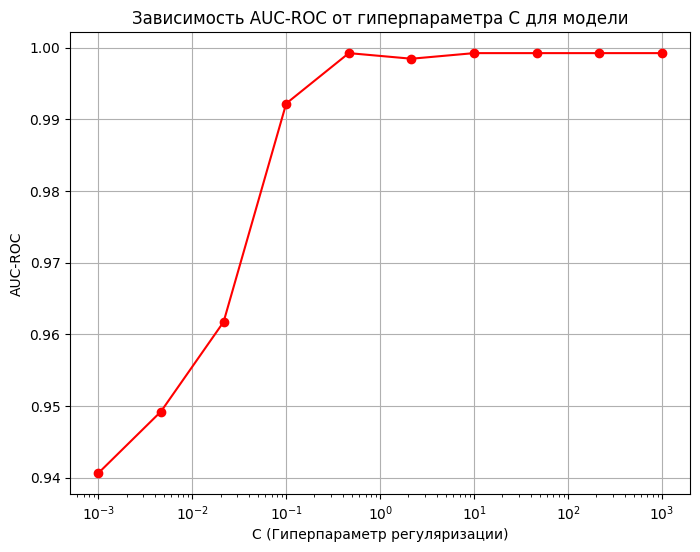

In [11]:
# Предполагаем, что вы уже использовали GridSearchCV и у вас есть результаты в grid
results = pd.DataFrame(grid.cv_results_)  # Результаты GridSearchCV

# Построение графика зависимости AUC-ROC от гиперпараметра C
plt.figure(figsize=(8, 6))
plt.semilogx(results['param_C'], results['mean_test_score'], marker='o', color='r')  # 'param_C' - гиперпараметр C
plt.xlabel('C (Гиперпараметр регуляризации)')
plt.ylabel('AUC-ROC')
plt.title('Зависимость AUC-ROC от гиперпараметра C для модели')
plt.grid(True)
plt.show()

In [12]:

# Сохранение бейслайна в CSV
baseline_metrics = []

# Проходим по каждой строке и добавляем данные в словарь
for i in range(len(df)):
    row_metrics = {
        'CustomerID': df['CustomerID'].iloc[i],
        'Genre': df['Genre'].iloc[i],
        'Age': df['Age'].iloc[i],
        'Annual Income (k$)': df['Annual Income (k$)'].iloc[i],
        'Spending Score (1-100)': df['Spending Score (1-100)'].iloc[i],
        'Best_C': best_C,  # Значение гиперпараметра C из grid search
        'AUC-ROC': auc_score  # AUC-ROC для модели
    }
    baseline_metrics.append(row_metrics)

# Создание DataFrame из списка словарей
baseline_df = pd.DataFrame(baseline_metrics)

# Сохранение в CSV файл
baseline_path = 'baseline_metrics.csv'
baseline_df.to_csv(baseline_path, index=False)

# Печать первых 5 строк
print(baseline_df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

     Best_C   AUC-ROC  
0  0.215443  0.997442  
1  0.215443  0.997442  
2  0.215443  0.997442  
3  0.215443  0.997442  
4  0.215443  0.997442  
